Epoch [1/10], Loss: 0.0087
Epoch [2/10], Loss: 0.0054
Epoch [3/10], Loss: 0.0044
Epoch [4/10], Loss: 0.0037
Epoch [5/10], Loss: 0.0038
Epoch [6/10], Loss: 0.0029
Epoch [7/10], Loss: 0.0031
Epoch [8/10], Loss: 0.0025
Epoch [9/10], Loss: 0.0028
Epoch [10/10], Loss: 0.0024


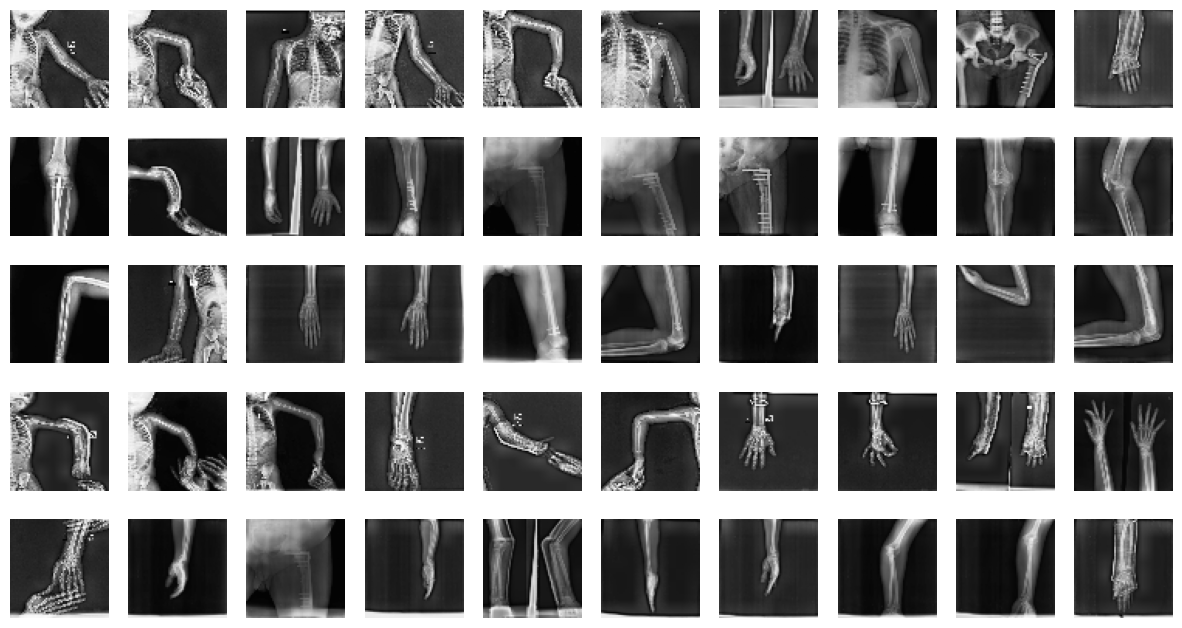

In [1]:
from utils import *

# Set random seed for reproducibility
tf.random.set_seed(42)

# Define a simple convolutional autoencoder
class ConvAutoencoder(tf.keras.Model):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(16, (3, 3), strides=2, padding='same', activation='relu'),  # Output: 16 x 14 x 14
            layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu'),  # Output: 32 x 7 x 7
            layers.Conv2D(64, (7, 7), padding='valid', activation='relu')  # Output: 64 x 1 x 1
        ])
        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(32, (7, 7), padding='valid', activation='relu'),  # Output: 32 x 7 x 7
            layers.Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu'),  # Output: 16 x 14 x 14
            layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same', activation='sigmoid')  # Output: 1 x 28 x 28
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Load and preprocess images
images, labels = load_dataset_split('FracAtlas/images')

# Create TensorFlow dataset
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(images)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Initialize model, loss, and optimizer
model = ConvAutoencoder()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.MeanSquaredError()

# Train the autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    for batch in dataset:
        with tf.GradientTape() as tape:
            reconstructed = model(batch)
            loss = loss_fn(batch, reconstructed)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.numpy():.4f}")

# Extract features using the encoder
def extract_features(images, model):
    features = model.encoder(images).numpy()
    features = features.reshape(features.shape[0], -1)  # Flatten features
    return features

# Get features for the entire dataset
features = extract_features(images, model)

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust n_clusters as needed
cluster_labels = kmeans.fit_predict(features)

# Visualize some clustered images
def plot_clusters(images, cluster_labels, num_samples=10):
    fig, axes = plt.subplots(nrows=5, ncols=num_samples, figsize=(15, 8))
    for cluster in range(5):
        cluster_indices = np.where(cluster_labels == cluster)[0][:num_samples]
        for i, idx in enumerate(cluster_indices):
            img = images[idx].squeeze()
            axes[cluster, i].imshow(img, cmap='gray')
            axes[cluster, i].axis('off')
    plt.show()

plot_clusters(images, cluster_labels)

In [2]:
filename = 'body_part_class_v2.pkl'

create_pkl(filename, kmeans)

¡¡¡¡LIMPIAR CUANDO SUBA A GITHUB!!!!